<a href="https://colab.research.google.com/github/tuanaasuokturk/MBC_data_analysis/blob/main/Assignment_2_ipynb_Solutions.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Load the numerical judgment dataset

We will now use the dataset from the other experiment from the article that we used in the previous two tutorials (Talluri et al.,*Current Biology*): the **numerical judgment dataset**. The paradigm is presented in Figure 3 of the [article](https://www.cell.com/action/showPdf?pii=S0960-9822%2818%2930982-5). The structure of each trial is conceptually identical to the orientation judgment task:
- first, a stimulus (here a sequence of number)
- a discrimination task on this first stimulus (is the mean larger than 50?)
- then a second stimulus (another sequence of numbers)
- finally, a numerical judgment task (report the mean over the *two* sequences).

We will address with linear regression the scientific question under focus in the original article: **is the judgment task corrupted by a confirmatory bias, i.e. a tendency to align their judgment with the intermittent choice?** More specifically, we will ask **whether subjects downweight evidence from the second stimulus if it is at odds with their intermediate choice** (i.e. if their intermediate choice was ">50" and numbers in the second stimuli are small). The analyses we run will be a simplified version of the analyses in the original article.

Load the data as a Pandas dataframe (as in Assignment 1). `x1` now represents the average value of numbers in the first sequence, and correspondingly for `x2`. Note also that this dataframe has one extra column, `binchoice`, which codes for the response of the subject on the classification task after stimulus 1 (-1: "<50"; 1: ">50").

In [1]:
# import typical packages
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

# load the data from github
df = pd.read_csv("https://raw.githubusercontent.com/wimmerlab/MBC_data_analysis/main/A2_LinearRegression/Task_Numerical.csv",sep=',')

# uncomment if you prefer to load the data locally
#df = pd.read_csv("Task_Numerical.csv",sep=',')

# list of subjects
subjects = np.unique(df.subj)

df.head()

,x1,binchoice,x2,xavg,estim,subj
0,45.375,-1,41.625,43.5000,44,1
1,47.500,1,38.625,43.0625,41,1
2,47.750,1,57.500,52.6250,54,1
3,46.625,-1,38.375,42.5000,40,1
4,47.250,-1,41.375,44.3125,45,1


## 1. Simple linear regression
We will start by looking at the relationship between the subject report $y$ (i.e. variable `estim`, the reported mean at the end of the sequence) and a single measure: the mean over the whole sequence ``xavg``. We will assume a linear relationship: $y = \beta_1 xavg + \beta_0 + \text{noise}$, where $\beta_0$ is the intercept,  $\beta_1$ is the slope, and the noise is zero-mean gaussian (with constant variance). This is the generative formula for simple linear regression. Our goal here is to estimate the values of the parameters $(\beta_0,\beta_1)$ from the data.

### 1.1 Naive fitting
To start with, we will adopt a naive strategy where we adjust manually the linear curve (i.e. the formula above, without the noise) so it captures the data as good as possible. This should give us more insight about the role of the intercept and slope.

**Define a function that captures the linear relationship between xavg and y,  taking the intercept and slope as input.**

In [2]:
def linear_function(x, beta0, beta1):
    """
    Computes the linear function
    Args:
       X (array): value(s) of the regressor
       beta0 (float): intercept
       beta1 (float): slope
    """

    # use linear relationship
    y = beta0 + beta1 * x

    # output the result
    return y

Now **complete the code below and run the cell**. It plots the function with have just defined (red line), along with the data points from one subject (each blue point represents a single trial). **Adjust the value of the slides to best capture the relationship between the average stimulus and the report from the data**.

In [3]:
import ipywidgets as widgets       # interactive display
#@title

#select data from subject 1
df1 = df[df.subj==1]

#@markdown Make sure you execute this cell to enable the widget!

@widgets.interact(
    beta0 =widgets.FloatSlider(20, min=0, max=50), # default, min and max values for intercept
    beta1 =widgets.FloatSlider(0.1, min=0.0, max=1.0)) # defaul, min and max values for slope

def plot_data_estimate(beta0, beta1):

    # set x-values for your prediction, linearly scaled values (could be just two as we're drawing a line)
    x_data = np.linspace(35,65,10)

    # given the values in x_data, predict y_data values from our model with given parameters
    y_data = linear_function(x_data, beta0, beta1)

    # plot
    plt.plot(x_data, y_data, 'r') # plot the model prediction with a line
    plt.plot(df1.xavg, df1.estim, 'bo') # now plot the true data from our dataframe df as dots
    plt.xlabel('average stimulus');
    plt.ylabel('subject report');

    # Add a dotted line indicating the identity line
    plt.plot(x_data, x_data, linestyle='--', color='gray');

    plt.show(); # needed for Colab

interactive(children=(FloatSlider(value=20.0, description='beta0', max=50.0), FloatSlider(value=0.1, descripti…

This was nice but we ignored the stochastic part of the linear regression model (the added Gaussian noise) which we would like to estimate as well, as it gives us an estimate of how much the model cannot explain about the data. To do so, we now need to simulate the model with noise and compare the distributions of points to the experimental one.
First, **write a function that simulates the linear regression model (with noise), given some values of the regressor $xavg$ and parameter values**. Parameters now include the intercept $\beta_0$, the slope $\beta_1$ and also $\sigma$, the standard deviation of the Gaussian noise. A Gaussian random variable can be drawn using `random` from the `numpy` package.

In [4]:
#import function
from numpy.random import normal

# define function that simulates the linear regression model
def generate_linear_model(x, intercept, slope, sigma):
    """
    Simulates the simple linear model
    Args:
       X (array): value(s) of the regressor
       beta0 (float): intercept
       beta1 (float): slope
       sigma (float): standard deviation of noise parameter
    """

    # use linear relationship
    y = intercept + slope*x

    # add gaussian noise with standard deviation = sigma
    n = len(x)
    y = y + sigma * normal(size=n)

    # output the result
    return y

Now run the cell below where the black dots represent model simulations while blue dots represent the data. Play with the knobs and **adjust the parameter values to match the two distribution qualitatively**.

In [5]:
@widgets.interact(
    beta0 =widgets.FloatSlider(20, min=0, max=50), # default, min and max values for intercept
    beta1 =widgets.FloatSlider(0.1, min=0.0, max=1.0), # defaul, min and max values for slope
    sigma = widgets.FloatSlider(1, min=0.0, max=20.0)) # defaul, min and max values for noise

def plot_simulated_vs_real_data_estimate(beta0, beta1, sigma):

     # set x-values for your prediction, same as original dataset
    x_data = df1.xavg

     # given the values in x_data, predict y_data values from model with given parameters
    y_data = generate_linear_model(x_data, beta0, beta1,sigma)

    #plot
    plt.plot(x_data, y_data, 'ko') # plot the model prediction with black dots
    plt.plot(df1.xavg, df1.estim, 'bo') # now plot the true data from our dataframe df as blue dots
    plt.xlabel('average stimulus');
    plt.ylabel('subject report');

    # Add a dotted line indicating the identity line
    plt.plot(x_data, x_data, linestyle='--', color='gray');

    plt.show(); # needed for Colab

interactive(children=(FloatSlider(value=20.0, description='beta0', max=50.0), FloatSlider(value=0.1, descripti…

### 1.2 Least-square regression

We will now use a more principled approach called Ordinary Least-Square (OLS) regression, which minimizes the overall estimation error of the linear model. More precisely, it looks for the parameters $(\beta_0,\beta_1)$ that minimizes the sum over trials of the squares of errors.
**Run OLS regression for subject 1 and obtain the coefficients of the linear regression that fits the data.**

 We can run this analysis with the function `ols` in `statsmodel.formula.api`. You just need to specify the formula (the dependent variable on the left, and the regressor(s) on the right) and the dataframe for the corresponding data.

In [6]:
# import OLS from statsmodel package
from statsmodels.formula.api import ols

# define model formula and database (point to a dataframe)
mod = ols(formula = 'estim ~ xavg', data=df1)

# fit the model
res = mod.fit()

# The coefficients
print('Coefficients:', res.params)

Coefficients: Intercept    21.133246
xavg          0.658960
dtype: float64


You get a more complete summary using the command `summary`, including the $R^2$ (how much variance in the dependent variable does the model explains, from 0 to 1), and the confidence interval for each parameter - very useful if we want to determine if a weight is statistically different from 0 (check also the t-statistic).

In [7]:
#print the summary
res.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  estim   R-squared:                       0.251
Model:                            OLS   Adj. R-squared:                  0.241
Method:                 Least Squares   F-statistic:                     26.77
Date:                Sun, 02 Nov 2025   Prob (F-statistic):           1.66e-06
Time:                        11:24:14   Log-Likelihood:                -243.67
No. Observations:                  82   AIC:                             491.3
Df Residuals:                      80   BIC:                             496.2
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     21.1332      6.473      3.265      0.002       8.252      34.015
xavg           0.6590      0.127      5.174      0.000       0.406       0.912
==============================================================================
Omnibus:                        0.613   Durbin-Watson:                   1.426
Prob(Omnibus):                  0.736   Jarque-Bera (JB):                0.579
Skew:                           0.197   Prob(JB):                        0.749
Kurtosis:                       2.879   Cond. No.                         623.
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

**Interpret the value of $R^2$.**

*The value is 0.251, i.e. our simple linear relationship explains about 25% of the variance in this subject reports. Explained variance in behavioral models is typically low, just because behavior is rich and cannot be constrained by a few experimental conditions. It doesn't matter so much: what matters is that the linear model (grossly) captures the dependence of the reports on the experimental conditions.*

**How do the fitted coefficients compare to the ones we adjusted by hand?**

*In my case, not too bad...at least within the confidence interval.*

What about the noise parameter $\sigma$? The estimated value is not provided directly in the table but we can easily compute it as the *root mean square error* (RMSE), i.e. $\hat \sigma = \sqrt {\frac 1 n \sum_i e_i^2}$ where $ \frac 1 n \sum_i()$ refers to the mean over trials and $e_i$ is the *residual* (or error) for trial $i$, i.e. the difference on each trial between the expected value of the report (following the noiseless linear relationship) and the observed value.
The array of residuals can be obtained using `res.resid`.
**Compute the root mean square error.**

In [8]:
# Compute the mean square error
mse = np.mean(res.resid**2)

# Take the square root
rmse = np.sqrt(mse)

print("Root Mean Squared Error (RMSE):", rmse)

Root Mean Squared Error (RMSE): 4.724205577915148


**Compare to the value of noise adjusted by hand.**

*I had $\sigma = 4.4$, so not too far away from the fitted value.*

### 1.3 Analysis of residuals
Should we believe these results?

One of the underlying assumption when using linear regression is the **normal distribution of independent residual errors**. It basically means two things:
- that the noise in the model should be independent from the value of the regressor (a property that goes by the ugly name of *homoskedasticity*). Sometimes this hypothesis is not met, usually because of outliers, and that can corrupt the result of our analysis. We can check whether this is the case *a posteriori* by looking at the profile of the residuals.  The variability of these residuals should not change depending on the regressor value (here, stimulus average).
- That the noise comes a Gaussian distribution. For this, we can check a posteriori that distribution the residuals is more or less Gaussian.

Watch the [second video on linear regression above](https://youtu.be/xIDjj6ZyFuw?si=QES8GYRwbY4H8Lu0&t=290) to understand these checks.

Let's perform the first check . **Check this by plotting a scatter plot of model residuals vs. the value of the regressor**. Note that this is basically equivalent to removing the linear trend from the scatter plot of (stimulus, response).

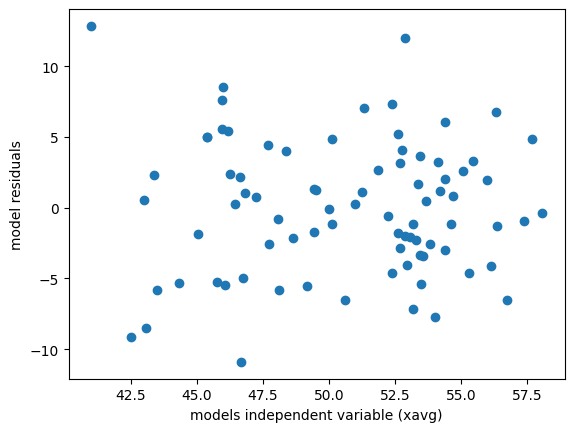

In [9]:
plt.figure();

# plot the residuals versus the independent variable X in a scatter plot
plt.scatter(df1.xavg, res.resid);
plt.ylabel('model residuals');
plt.xlabel('model''s independent variable (xavg)');

**What do we learn from this plot?**

*The variability of the residual seems pretty homogeneous across value of the stimulus average (distributed around the 0 value), so it looks like we can safely use linear regression here.*

Now let's perform the second check: that the residuals are normally distributed. **Plot the distribution of residuals.**

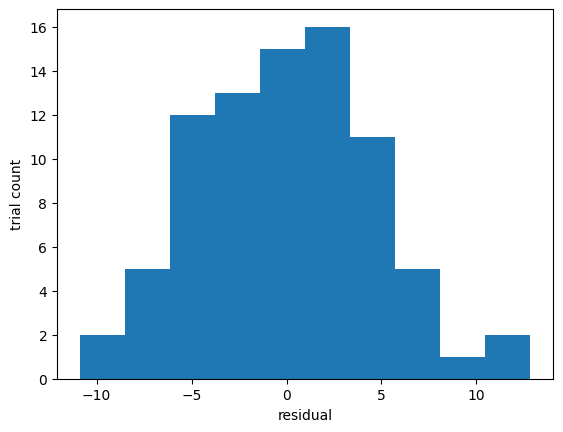

In [10]:
plt.figure;
plt.hist(res.resid);
plt.xlabel('residual');
plt.ylabel('trial count');

**What do you conclude?**

*The number of data points is quite small to get a nice curve but it does have the typical bell shaped curve of the Gaussian, so normality seems a reasonable assumption.*

This can be done in a more principled manner using quantile-quantile plots with `probplot` (from the `scipy` package). This is some (nonlinear) rescaling the cumulative histogram of the residuals so that, if the residuals are indeed normally distributed, the curve (marked by blue points) should not depart too far from the (red) diagonal line. As you can see, this is the case (except perhaps the little deviation on the far right which is due to the two errors larger than 10 - those two trials may be outliers).

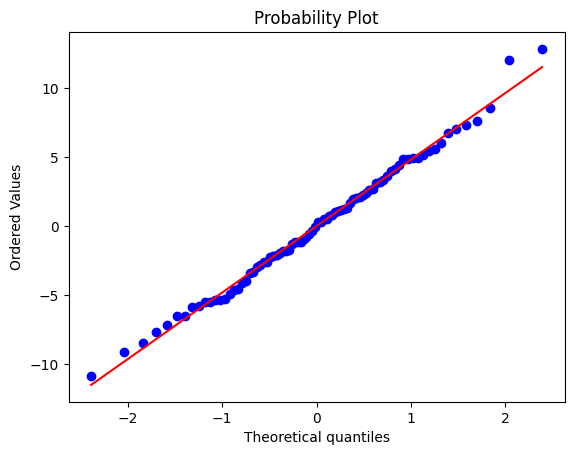

In [11]:
# import the function
from scipy.stats import probplot

# draw quantile-quantile plot
plt.figure;
probplot(res.resid, plot=plt);

**What do you conclude from all these checks?**

*We passed both tests, so we can safely interpret the result of our linear regression analysis. This is something that you should be done for all analyses (although in practice very few do it in neuroscience).*

## 2. Multiple linear regression
Multiple linear regression extends the framework above to **estimate jointly the impact of various regressors** (or *independent variables*) on the dependent variable. For example, the simple linear regression above used only the average of the two stimuli as a regressor, which implicitly assumes that both stimuli have the same impact on participant reports. But there is no reason to assume it, and indeed across many tasks humans and non-human subjects tend to weigh differently different pieces of information when they are provided sequentially. Sometimes they weigh more the earlier stimuli (*primacy effect*), sometimes they weigh more the later stimuli (*recency effect*), sometimes it's more complicated.
We can estimate this using multiple linear regression where each stimuli are provided as independent regressors.
**Implement this regression analysis, again for subject 1.** You basically just need to update the formula from the single linear model, replacing the single regressor with the sum of the two regressors.

In [12]:
# define the multiple linear regression model
mod = ols(formula = 'estim ~ x1 + x2', data=df1)

# fit to data
res = mod.fit()

# print the summary
res.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  estim   R-squared:                       0.281
Model:                            OLS   Adj. R-squared:                  0.263
Method:                 Least Squares   F-statistic:                     15.46
Date:                Sun, 02 Nov 2025   Prob (F-statistic):           2.15e-06
Time:                        11:24:15   Log-Likelihood:                -241.96
No. Observations:                  82   AIC:                             489.9
Df Residuals:                      79   BIC:                             497.1
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     29.4845      7.837      3.762      0.000      13.886      45.083
x1             0.0870      0.146      0.595      0.554      -0.204       0.378
x2             0.4005      0.074      5.432      0.000       0.254       0.547
==============================================================================
Omnibus:                        0.525   Durbin-Watson:                   1.371
Prob(Omnibus):                  0.769   Jarque-Bera (JB):                0.669
Skew:                           0.153   Prob(JB):                        0.716
Kurtosis:                       2.680   Cond. No.                     1.08e+03
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 1.08e+03. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

**Plot the value of the weights for the two stimuli as a bar plot (with standard error as error bars).** The value of the weights (starting with the intercept) can be accessed through `res.params[:]`, while the standard errors are called by `res.bse[:]`,

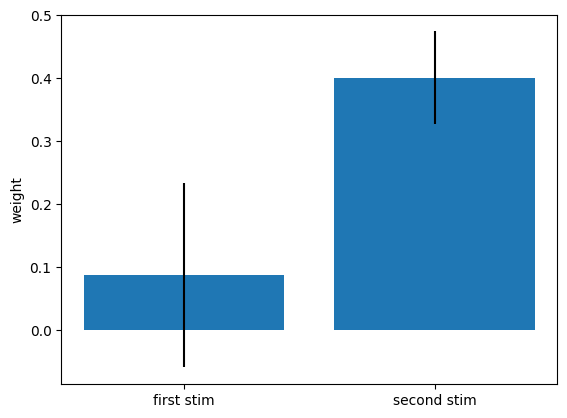

In [13]:
#creat figure
plt.figure

# add bar plot with weights of the first and second stimulus
plt.bar(range(2),res.params[1:])

# add error bars with standard error of these weights
plt.errorbar(range(2), res.params[1:], res.bse[1:],  fmt='k',linestyle='None');

# add tick and axes labels
plt.xticks(range(2), ["first stim","second stim"]);
plt.ylabel('weight');

**What do you conclude?**

*The second stimulus has a larger impact on the report than the first one, for this subject (and this looks statistically significant given the standard errors).*

At this stage we will make a rapid change in the definition of the variables to ease the following analyses, using 50 as the reference point as it was used in the experiment. We will change $x_1$ to $x_1-50$ so that a positive value indicates evidence towards large mean (>50) and a negative value indicates evidence towards low mean (<50). This is done in the code below. Then we can pass the same analysis again and check that it actually does not change anything to the stimulus weights! (Although it does change the intercept)

In [14]:
# use 50 as reference point
df.x1 = df.x1 - 50
df.x2 = df.x2 - 50
df.xavg = df.xavg - 50
df.head()

,x1,binchoice,x2,xavg,estim,subj
0,-4.625,-1,-8.375,-6.5000,44,1
1,-2.500,1,-11.375,-6.9375,41,1
2,-2.250,1,7.500,2.6250,54,1
3,-3.375,-1,-11.625,-7.5000,40,1
4,-2.750,-1,-8.625,-5.6875,45,1


In [15]:
# dataframe for first subject
df1 = df[df.subj==1]

# re-define the multiple linear regression model
mod = ols(formula = 'estim ~ x1 + x2', data=df1)

# fit to data again
res = mod.fit()

# print the summary
res.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  estim   R-squared:                       0.281
Model:                            OLS   Adj. R-squared:                  0.263
Method:                 Least Squares   F-statistic:                     15.46
Date:                Sun, 02 Nov 2025   Prob (F-statistic):           2.15e-06
Time:                        11:24:15   Log-Likelihood:                -241.96
No. Observations:                  82   AIC:                             489.9
Df Residuals:                      79   BIC:                             497.1
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     53.8585      0.541     99.593      0.000      52.782      54.935
x1             0.0870      0.146      0.595      0.554      -0.204       0.378
x2             0.4005      0.074      5.432      0.000       0.254       0.547
==============================================================================
Omnibus:                        0.525   Durbin-Watson:                   1.371
Prob(Omnibus):                  0.769   Jarque-Bera (JB):                0.669
Skew:                           0.153   Prob(JB):                        0.716
Kurtosis:                       2.680   Cond. No.                         7.61
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

## 3. Population analysis
OK, this was just one subject. When we look for an effect in the general population, we use a two-level analysis:
* 1) Fit the linear regression model for each subject, separately
* 2) Compare the distribution of weights across subjects (e.g. with t-tests)

**Use this two-level approach.** First, fit the same regression analysis for all subjects separately (with the two stimuli as regressors) and store the weights of all subjects. Then, plot the average value (across subjects) of the weights for stimulus 1 and stimulus 2 as a bar plot, with individual lines for the weights of individual subjects.

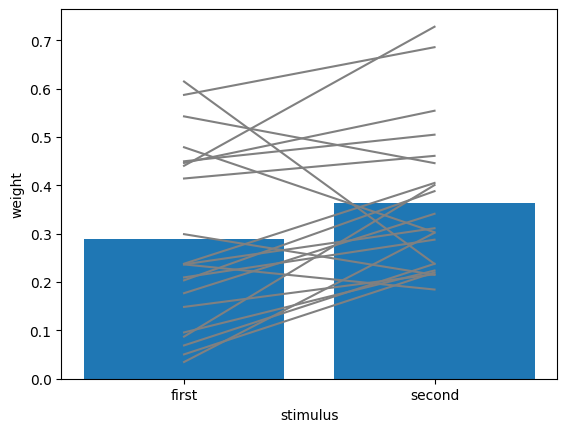

In [16]:
#define numpy array where we will store the weights for all subjects
pars = np.zeros((len(subjects),3))

# loop through all subjects
for i,s in enumerate(subjects):

    # dataframe with data only for the corresponding subject
    df_subj = df[df.subj==s]

    # define the corresponding model
    mod = ols(formula = 'estim ~ x1 + x2', data=df_subj)

    # fit the model
    res = mod.fit()

    # add the model weights to the array
    pars[i,:] = res.params


# compute the mean of all weights across subjects (axis defines if we average over rows or columns)
mean_weights = np.mean(pars,axis=0)

# create figure
plt.figure;

# bar plot for mean weights for stimulus 1 and 2
plt.bar(range(2),mean_weights[1:]);

# add grey lines for weights of individual subjects
for i in range(len(subjects)):
    plt.plot(range(2),pars[i,1:],'grey');

# add labels for ticks and axes
plt.xticks(range(2),("first","second"));
plt.xlabel("stimulus");
plt.ylabel("weight");

Now, **test formally whether there is a statistical difference across the population by using a *paired* t-test**. This is paired because for each subject we have a value for both distributions, that of the first and second stimulus weights. Paired t-tests are performed using `stats.ttest_rel`.

In [17]:
# Importing library
import scipy.stats as stats

# Performing the paired sample t-test
stats.ttest_rel(pars[:,1], pars[:,2])

TtestResult(statistic=np.float64(-2.1380748970935217), pvalue=np.float64(0.04503993674223998), df=np.int64(20))

**What do you conclude?**

*There's a marginally significant recency effect across the population, whereby subject reports tend to weigh more the second stimulus than the first.*

## 3. Testing the confirmation bias
We are now finally in a position to test the central hypothesis of the experiment: that the intermediate choice biases the perception of the subsequent stimulus, such that this second stimulus will have a larger weight on the final report if is consistent with the intermediate choice than if it is inconsistent. Take some time to make sure you get this, because now we will want to put this in a (simple) equation.
But first, let's **define a boolean array for this consistency and add it to the dataframe**. The value of the array should be true if the sign of `binchoice` is the same as that of $x2$ (i.e. if they are both positive, it means that the subject responded ">50" at the intermediate choice, and that the mean of the second stimulus is above 50), false otherwise. Check that you did good.

In [18]:
# sign of x2
sgn = np.sign(df['x2'])

# define boolean array for consistency
consistent = sgn == df['binchoice']

# add to dataframe
df['consistent'] = consistent
df.head()

,x1,binchoice,x2,xavg,estim,subj,consistent
0,-4.625,-1,-8.375,-6.5000,44,1,True
1,-2.500,1,-11.375,-6.9375,41,1,False
2,-2.250,1,7.500,2.6250,54,1,True
3,-3.375,-1,-11.625,-7.5000,40,1,True
4,-2.750,-1,-8.625,-5.6875,45,1,True


The previous model (with no impact of the intermediate binary choice on the judgment) can be written as $y = \beta_0 + \beta_1 x_1 + \beta_2 x_2  + \text{noise}.$
How can we change this model to capture a different impact of the second stimulus depending on consistency with the intermediate choice?
**Write the equation below** (or equivalently, the definition of the regressors).

*We should have a different weight for $x_2$ depending on whether it is consistent or not, i.e.
$y = \beta_0 + \beta_1 x_1 + \beta_2 x_{2C} + \beta_3 x_{2I}  + \text{noise}$, where $x_{2C}=x_2$ if $x2$ is consistent with the choice (and equal to 0 otherwise), and $x_{2I}=x_2$ if $x2$ is inconsistent with the choice (and equal to 0 otherwise). We can actually use equations $x_{2C} = x_2 C$ and $x_{2I} = x_2 (1-C)$, where $C$ is the value of consistency (1 if true, 0 if false). So basically we need another regression model with now three regressors: $x_1$, $x_{2C}$ and $x_{2I}$.*

Now **add the two new regressors that you will need in the new regression model as variables to the dataframe.** Again, take some time to make sure on the first lines of the dataframe that the new variables do code what we expect them to code.

In [19]:
# x2con: equal to x2 if consistent, 0 otherwise
x2con = df['x2'] * consistent

# x2inc: equal to x2 if inconsistent, 0 otherwise
x2inc = df['x2'] * ~consistent # could use (1-consistent) instead of ~consistent

# add as variables in dataframe
df['x2con'] = x2con
df['x2inc'] = x2inc

df.head()

,x1,binchoice,x2,xavg,estim,subj,consistent,x2con,x2inc
0,-4.625,-1,-8.375,-6.5000,44,1,True,-8.375,-0.000
1,-2.500,1,-11.375,-6.9375,41,1,False,-0.000,-11.375
2,-2.250,1,7.500,2.6250,54,1,True,7.500,0.000
3,-3.375,-1,-11.625,-7.5000,40,1,True,-11.625,-0.000
4,-2.750,-1,-8.625,-5.6875,45,1,True,-8.625,-0.000


Almost there! Now **fit the new regression model on all subjects separately and plot the values of the two types of x2 weights one against another**. Specifically, instead of plotting lines as we did for the previous model, we will represent each pair of weights using a scatter plot, with the value of one weight on the x-axis and of the other weight on the y-axis. This way, systematic differences between the weights will be seen as points lying more on one side or the other of the diagonal.

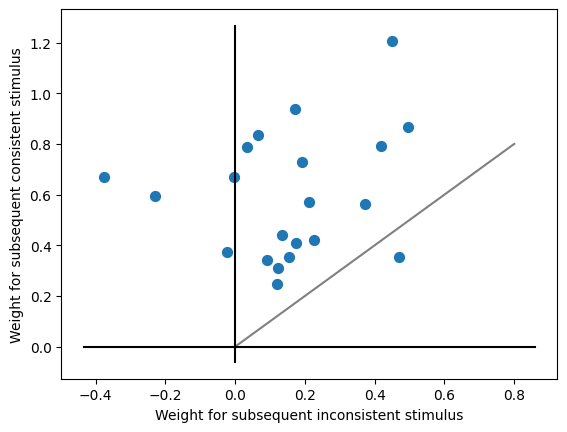

In [20]:
# create array for weights for each subject (how many weights per subject?)
pars = np.zeros((len(subjects),4))

# loop through all subjects
for i,s in enumerate(subjects):

    # dataframe for this subject
    df_subj = df[df.subj==s]

    # define and fit regression model
    mod = ols(formula = 'estim ~ x1 + x2con + x2inc', data=df_subj)
    res = mod.fit()

    # store values of the parameters
    pars[i,:] = res.params

# compute mean across subjects
mean_weights = np.mean(pars,axis=0)

# create figure
plt.figure;

# add scatter plot, with values of one set of weights as X, and of the other set of weights as Y
plt.scatter(pars[:,3],pars[:,2], s=50);

# add gray diagona line
plt.plot((0,.8),(0,.8),'gray');

# vertical and horizontal lines at 0
plt.plot(plt.xlim(),(0,0),'k');
plt.plot((0,0),plt.ylim(),'k');

# axis labels
plt.ylabel("Weight for subsequent consistent stimulus");
plt.xlabel("Weight for subsequent inconsistent stimulus");

**Perform a paired T-test between the two sets of weights.**

In [21]:
# Performing the paired sample t-test
stats.ttest_rel(pars[:,2], pars[:,3])

TtestResult(statistic=np.float64(6.775840240142294), pvalue=np.float64(1.370653896457527e-06), df=np.int64(20))

**What do you conclude?**

*The difference is highly significant ($p<10^{-5}$), showing that indeed the weight of the second stimulus is smaller if it is inconsistent with the preceding binary choice. We have confirmed our hypothesis in the data!*

## 4 Modelling the whole population with a single model

### 4.1 Naive approach with categorical variables
We have seen above the typical two-level analysis when looking for an effect in a population of subjects: fit one model on each subject separately, and then compare the distribution of weights across participants. We will now explore single-step approaches where we would capture the whole dataset with a single regression model. The challenge is to take into account the variability of effects between different subjects in a single model.

We will start with a naive approach that will illustrate how to use **categorical regressors**.
So let's say we want to capture the variability of participant biases, i.e. their idiosyncratic tendency to over- or under-evaluate the stimulus mean in their reports. In the linear model, this is captured by the intercept $\beta_0$.
So what we would like is a different intercept for each subject. This is done by adding subject identity as a categorical regressor in the design of a general linear model, which means simply `C(subj)` to the formula. This will estimate one weight for each subject (except the first subject taken as the reference).
Note that this is different from simply adding `subj`, which would introduce a continuous instead of categorical regressor (i.e. it would capture a linear trend for later subjects to over-estimate or under-estimate compared to earlier subjects - this is not what we want!).
**Add subject as a categorical variable to the linear regression model with x1 and x2 as regressors, and fit to the whole dataset.**

In [22]:
# define the multiple linear regression model
mod = ols(formula = 'estim ~ x1 + x2 + C(subj)', data=df)

# fit to data
res = mod.fit()

# print the summary
res.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  estim   R-squared:                       0.302
Model:                            OLS   Adj. R-squared:                  0.293
Method:                 Least Squares   F-statistic:                     33.74
Date:                Sun, 02 Nov 2025   Prob (F-statistic):          4.89e-117
Time:                        11:24:17   Log-Likelihood:                -5444.9
No. Observations:                1738   AIC:                         1.094e+04
Df Residuals:                    1715   BIC:                         1.106e+04
Df Model:                          22                                         
Covariance Type:            nonrobust                                         
=================================================================================
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
Intercept        54.0018      0.618     87.348      0.000      52.789      55.214
C(subj)[T.2]     -2.3611      0.867     -2.722      0.007      -4.062      -0.660
C(subj)[T.3]     -7.4855      0.870     -8.604      0.000      -9.192      -5.779
C(subj)[T.4]     -3.5873      0.867     -4.135      0.000      -5.289      -1.886
C(subj)[T.5]     -4.6111      0.867     -5.316      0.000      -6.312      -2.910
C(subj)[T.6]     -2.0998      0.870     -2.414      0.016      -3.806      -0.393
C(subj)[T.7]     -2.9682      0.867     -3.422      0.001      -4.670      -1.267
C(subj)[T.8]     -8.3966      0.875     -9.592      0.000     -10.114      -6.680
C(subj)[T.9]     -1.7063      0.867     -1.967      0.049      -3.408      -0.005
C(subj)[T.10]    -4.8730      0.867     -5.618      0.000      -6.574      -3.172
C(subj)[T.11]    -5.6111      0.867     -6.468      0.000      -7.312      -3.910
C(subj)[T.12]    -7.8611      0.867     -9.062      0.000      -9.562      -6.160
C(subj)[T.13]    -3.1508      0.870     -3.621      0.000      -4.857      -1.444
C(subj)[T.14]    -2.9948      0.870     -3.442      0.001      -4.701      -1.288
C(subj)[T.15]    -6.3611      0.867     -7.333      0.000      -8.062      -4.660
C(subj)[T.16]    -3.4682      0.867     -3.998      0.000      -5.170      -1.767
C(subj)[T.17]    -1.8254      0.867     -2.104      0.035      -3.527      -0.124
C(subj)[T.18]    -3.7897      0.867     -4.369      0.000      -5.491      -2.088
C(subj)[T.19]    -4.4395      0.875     -5.072      0.000      -6.156      -2.723
C(subj)[T.20]    -2.3928      0.873     -2.742      0.006      -4.104      -0.681
C(subj)[T.21]    -0.5260      0.903     -0.583      0.560      -2.296       1.244
x1                0.2900      0.038      7.615      0.000       0.215       0.365
x2                0.3661      0.019     19.149      0.000       0.329       0.404
==============================================================================
Omnibus:                       13.102   Durbin-Watson:                   1.902
Prob(Omnibus):                  0.001   Jarque-Bera (JB):               19.086
Skew:                           0.002   Prob(JB):                     7.17e-05
Kurtosis:                       3.513   Cond. No.                         156.
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

**Can you find the weights for the regressor of interest? Why are the other regressors not “of interest”? Why do we include them, then?**

*The regressors of interest are the stimulus weights. Their values is fairly similar to the average values over participants that we found when using the two-level approach in section 2).
The other regressors are not "of interest" because we don't really care about the biases for specific subjects - although we might if were interested in correlating subject-to-subject variability with for example personnality traits. We include them because they explain some part of the variability in the reports, and so improve the statistical power of our analysis.*

**How do you interpret subject weights?**

*Subject-specific weights give the value of the overall bias for this subject compared to the value for the reference subject (subject 1). In other words, the value of a subject overall bias is the sum of their specific weight and the intercept. For example, for subject 2, this sum is 54-2.36=52.74 which is larger than 50, so this subject slightly overestimated the stimulus mean overall.*

### 4.2 Linear mixed models
Now we will take is a more principled approach to it, *linear mixed models*. In this framework, we consider subjects as *random factors*, i.e. factors that are not of interest per se but that contribute to the variability. Instead of estimating one parameter per subject, these models directly estimate the variance of the weight across the population (assuming, again, Gaussian statistics). In this way, one parameter of variance will take care of the variability across participants. Linear models that include both fixed factors (the baseline effect in the whole population - what we are generally interested in) and random factors (a variance parameter accounting for a family of regressors) are called "mixed models". These are usually the way that we should model subjects in our designs. Mixed models in the case of linear regression are called linear mixed models.

Let us implement a linear mixed model where the random factor for the intercept of each participant. This is very similar to the traditional linear regression model we just defined with subject-specific biases, except that now we directly estimate the distribution of biases across the population, rather than each subject bias.

In [23]:
# import package
from statsmodels.formula.api import mixedlm

# define model:
# - the fixed effects are given in the formula as for ols
# - the random factor is defined by 'groups' (variable 'subj')
# - the random effects (which weights should vary per subject) is defined by re_formula (here, just the intercept so "~1")
mod_sub = mixedlm(formula='estim ~ x1 + x2', data=df, groups=df['subj'], re_formula="~1")

# fit the model
res_sub = mod_sub.fit(maxiter=500,method="nm", reml="false")

# show summary
res_sub.summary()

<class 'statsmodels.iolib.summary2.Summary'>
"""
         Mixed Linear Model Regression Results
========================================================
Model:            MixedLM Dependent Variable: estim     
No. Observations: 1738    Method:             REML      
No. Groups:       21      Scale:              31.2233   
Min. group size:  72      Log-Likelihood:     -5487.8269
Max. group size:  84      Converged:          Yes       
Mean group size:  82.8                                  
--------------------------------------------------------
              Coef.  Std.Err.   z    P>|z| [0.025 0.975]
--------------------------------------------------------
Intercept     50.166    0.502 99.922 0.000 49.182 51.150
x1             0.290    0.038  7.618 0.000  0.215  0.365
x2             0.366    0.019 19.152 0.000  0.329  0.404
Group Var      4.889    0.300                           
========================================================

"""

This model gives us a similar result to what we got when we modeled subjects as fixed factors above. But actually subjects will differ not only because of their overall bias, but also because of a different weighting of stimulus information. So a better model will incorporate this variability, by adding the first and second stimuli as random factors.

In [24]:
from statsmodels.formula.api import mixedlm

# same as above, but now the random effects include x1 and x2
mod_sub = mixedlm(formula='estim ~ x1 + x2', data=df, groups=df['subj'], re_formula="~x1+x2")
res_sub = mod_sub.fit(maxiter=500,method="nm", reml="false")

res_sub.summary()

/usr/local/lib/python3.12/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/usr/local/lib/python3.12/dist-packages/statsmodels/regression/mixed_linear_model.py:2206: ConvergenceWarning: MixedLM optimization failed, trying a different optimizer may help.
  warnings.warn(msg, ConvergenceWarning)
/usr/local/lib/python3.12/dist-packages/statsmodels/regression/mixed_linear_model.py:2218: ConvergenceWarning: Gradient optimization failed, |grad| = 22.063373
  warnings.warn(msg, ConvergenceWarning)


<class 'statsmodels.iolib.summary2.Summary'>
"""
          Mixed Linear Model Regression Results
=========================================================
Model:             MixedLM Dependent Variable: estim     
No. Observations:  1738    Method:             REML      
No. Groups:        21      Scale:              30.1139   
Min. group size:   72      Log-Likelihood:     -5470.9465
Max. group size:   84      Converged:          No        
Mean group size:   82.8                                  
---------------------------------------------------------
               Coef.  Std.Err.   z    P>|z| [0.025 0.975]
---------------------------------------------------------
Intercept      50.167    0.502 99.912 0.000 49.183 51.151
x1              0.289    0.046  6.291 0.000  0.199  0.379
x2              0.365    0.034 10.696 0.000  0.298  0.432
Group Var       4.904    0.319                           
Group x x1 Cov -0.108    0.025                           
x1 Var          0.015    0.004                           
Group x x2 Cov  0.001    0.015                           
x1 x x2 Cov     0.015    0.002                           
x2 Var          0.017    0.001                           
=========================================================

"""